In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from src.prompting import ASAP2Loader

c:\Users\alvar\miniconda3\envs\mentor-eval\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset: ASAP2

The **ASAP 2.0** (Automated Student Assessment Prize 2.0) dataset, hosted on Kaggle, is a large-scale collection of approximately 24,000 argumentative, source-based essays written by U.S. secondary students. Released in conjunction with a Learning Agency Lab and Vanderbilt University competition in July 2024, it was designed to advance automated essay scoring algorithms by incorporating diverse samples across demographic and economic backgrounds—helping reduce bias and improve fairness in educational assessment. Licensed under CC BY, the dataset facilitates research in natural language processing, writing diagnostics, and educational equity. You can explore and download it here: [https://www.kaggle.com/datasets/lburleigh/asap-2-0](https://www.kaggle.com/datasets/lburleigh/asap-2-0).

## Loader

The data was organized and divided into questions, answers, complementary texts, and rubrics. A loader allows selecting which components to load for the model. The dataset is divided in different exercise sets:

In [2]:
asap2 = ASAP2Loader()
all_prompts = asap2.get_prompts(include_rubric=True, include_exercise_texts=True, include_exam_characteristics=True)
print('Total number of prompts: ', len(all_prompts))

Total number of prompts:  24728


Example:

In [3]:
print(all_prompts[0])

## Complementary Exercise Texts

Driverless Cars Are Coming

Can you imagine a time in the future when no one buys cars because no one needs them anymore? Google cofounder Sergey Brin can. He envisions a future with a public transportation system where fleets of driverless cars form a public-transport taxi system. The cars he foresees would use half the fuel of today's taxis and offer far more flexibility than a bus. He believes such cars would fundamentally change the world.

Television and movies have long been fascinated with cars that could drive themselves. In reality, Google has had cars that could drive independently under specific conditions since 2009. Their cars have driven more than half a million miles without a crash, but so far, Google cars aren't truly driverless; they still alert the driver to take over when pulling in and out of driveways or dealing with complicated traffic issues, such as navigating through roadwork or accidents. So what roadblocks lie ahead for the a

Also, the student responses could be retrieved directly, without any contextual information:

In [4]:
responses = asap2.get_responses()
responses[0]

'The author suggests that studying Venus is worthy enough even though it is very dangerous. The author mentioned that on the planet\'s surface, temperatures average over 800 degrees Fahrenheit, and the atmospheric pressure is 90 times greater than what we experience on our own planet . His solution to survive this weather that is dangerous to us humans is to allow them to float above the fray. A "blimp-like" vehicle hovering 30 or so miles would help avoid the unfriendly ground conditions . At thirty-plus miles above the surface, temperatures would still be toasty at around 170 degrees Fahrenheit, but the air pressure would be close to that of sea level on Earth. So not easy conditions, but survivable enough for humans. So this would help make the mission capeable of completing.\r\n\r\nHe also mentions how peering at venus from a ship orbiting or hovering safely far above the planet can provide only limited insight on ground conditions because most forms of light cannot penertrate the 

and the grades, which are evaluated from 1 to 6:

In [5]:
grades = asap2.get_grades()
grades[0]

4.0

## Analysis

First, let's analyze the stundet response corpora:

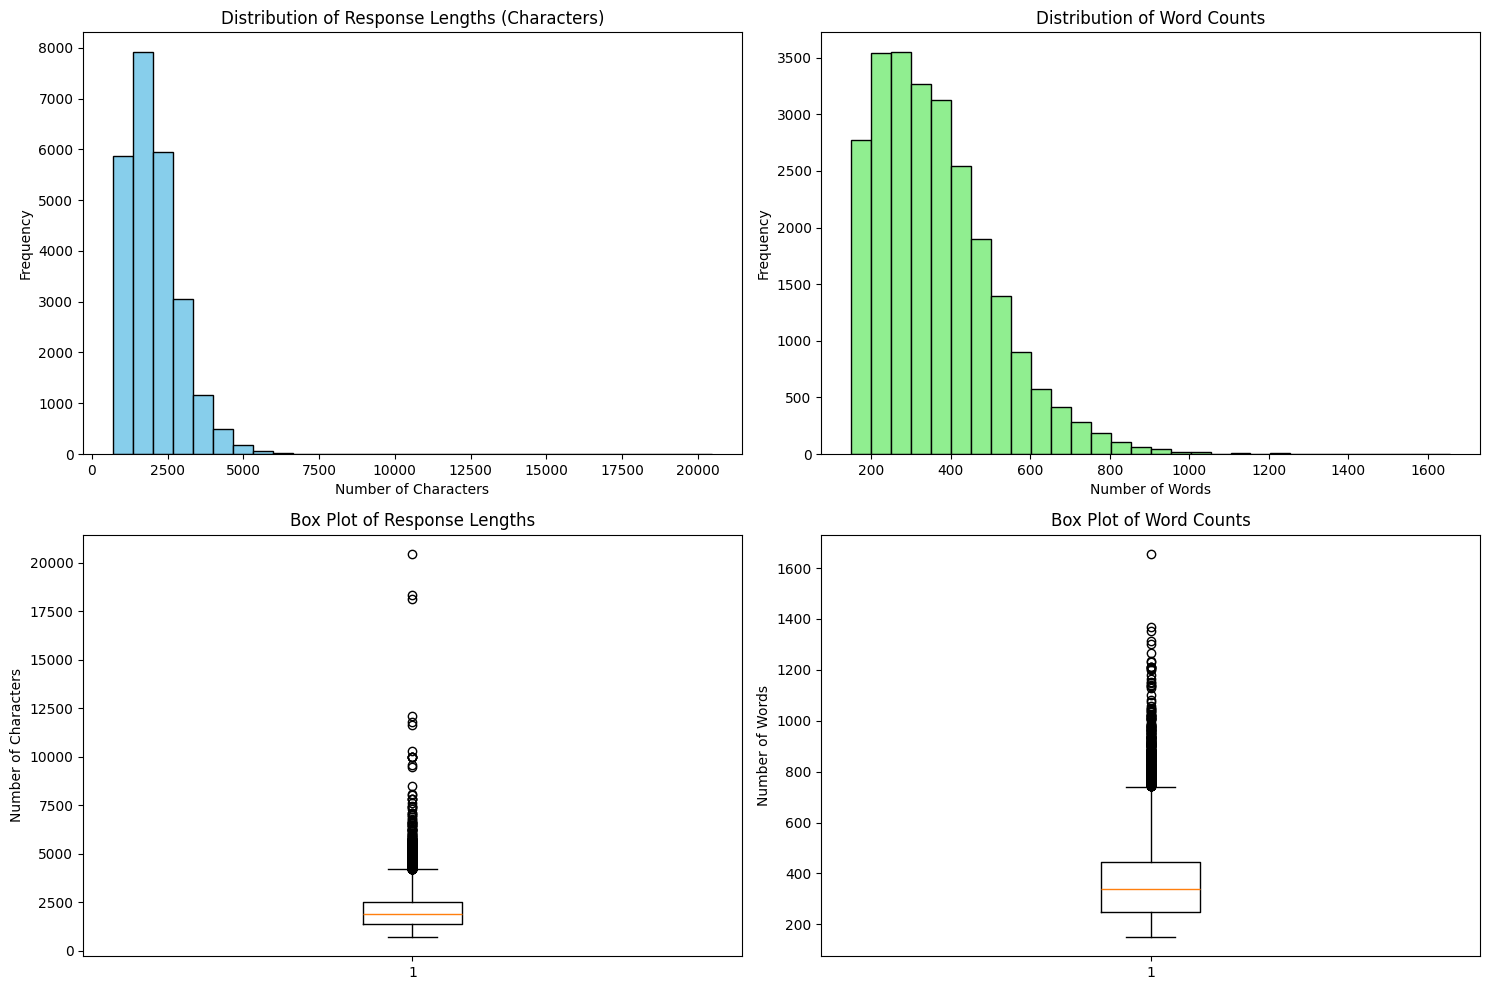


Summary Statistics:
Average response length: 2043.64 characters
Median response length: 1889.00 characters
Average word count: 362.90 words
Median word count: 338.00 words
Shortest response: 699 characters
Longest response: 20468 characters
Minimum words: 150 words
Maximum words: 1656 words


In [6]:
# Calculate lengths and word counts
response_lengths = [len(response) for response in responses]
word_counts = [len(response.split()) for response in responses]

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribution of response lengths
ax1.hist(response_lengths, bins=30, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Response Lengths (Characters)')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

# Plot 2: Distribution of word counts
ax2.hist(word_counts, bins=30, color='lightgreen', edgecolor='black')
ax2.set_title('Distribution of Word Counts')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')

# Plot 3: Box plot of response lengths
ax3.boxplot(response_lengths)
ax3.set_title('Box Plot of Response Lengths')
ax3.set_ylabel('Number of Characters')

# Plot 4: Box plot of word counts
ax4.boxplot(word_counts)
ax4.set_title('Box Plot of Word Counts')
ax4.set_ylabel('Number of Words')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average response length: {np.mean(response_lengths):.2f} characters")
print(f"Median response length: {np.median(response_lengths):.2f} characters")
print(f"Average word count: {np.mean(word_counts):.2f} words")
print(f"Median word count: {np.median(word_counts):.2f} words")
print(f"Shortest response: {min(response_lengths)} characters")
print(f"Longest response: {max(response_lengths)} characters")
print(f"Minimum words: {min(word_counts)} words")
print(f"Maximum words: {max(word_counts)} words")


Now, let's analyze the distribution of the grades:

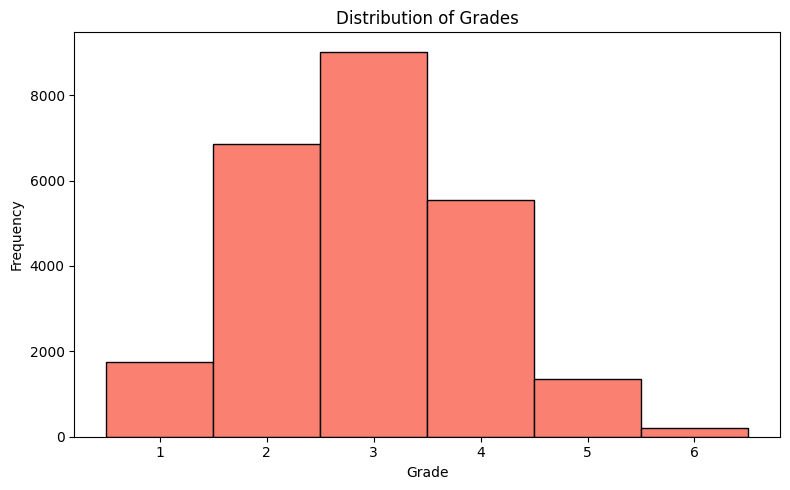

In [7]:
# Create figure
plt.figure(figsize=(8, 5))

# Plot histogram of grades
plt.hist(grades, bins=np.arange(0.5, 7.5, 1), color='salmon', edgecolor='black')
plt.title('Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(1, 7))

plt.tight_layout()
plt.show()


Resembles the normal distribution

# Baseline
As a baseline, I decided to use SentenceTransformer embeddings for machine learning. I chose the all-MiniLM-L6-v2 model for its lightweight nature and fast inference, since I'm currently unable to access any GPU in my environment. While fine-tuning a full BERT model would be ideal, this lightweight approach will serve as a good benchmark given that the main focus of this exploration is LLMs.

In [ ]:
# Initialize a smaller, faster model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Get embeddings for all responses at once (much faster than one at a time)
print("Getting embeddings for responses...")
bert_embeddings = model.encode(responses, show_progress_bar=True)

print(f"\nShape of embeddings: {bert_embeddings.shape}")

c:\Users\alvar\miniconda3\envs\mentor-eval\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\alvar\miniconda3\envs\mentor-eval\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alvar\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administr

Getting embeddings for responses...


Batches: 100%|██████████| 773/773 [39:00<00:00,  3.03s/it]


Shape of embeddings: (24728, 384)


In [7]:
bert_embeddings = np.load('bert_embeddings.npy')
np.save('bert_embeddings.npy', bert_embeddings)

 We establish our baseline using machine learning models with SentenceTransformer embeddings:
 1. Logistic Regression: Simple linear model to establish a basic performance threshold
 2. Random Forest: Tree-based ensemble to capture non-linear patterns
 3. Neural Network: Simple feed-forward network to learn complex patterns
 4. CNN: Convolutional network to capture local patterns in the embeddings

We evaluate each model using accuracy and confusion matrices to understand their performance
and error patterns. This gives us a comprehensive baseline to compare against LLM-based approaches.


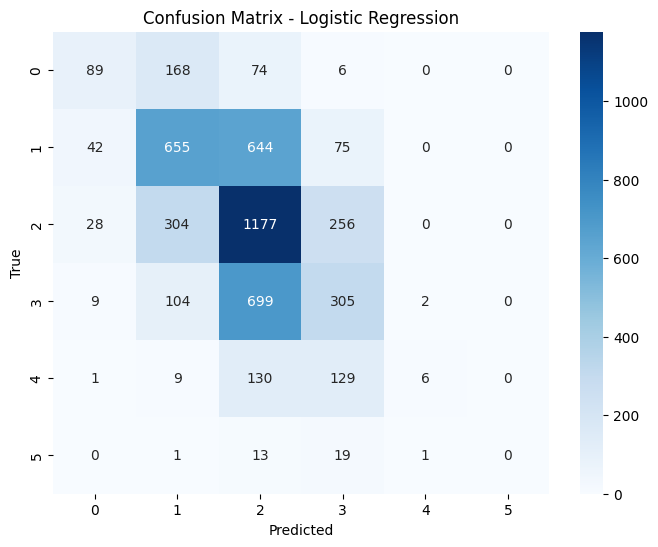

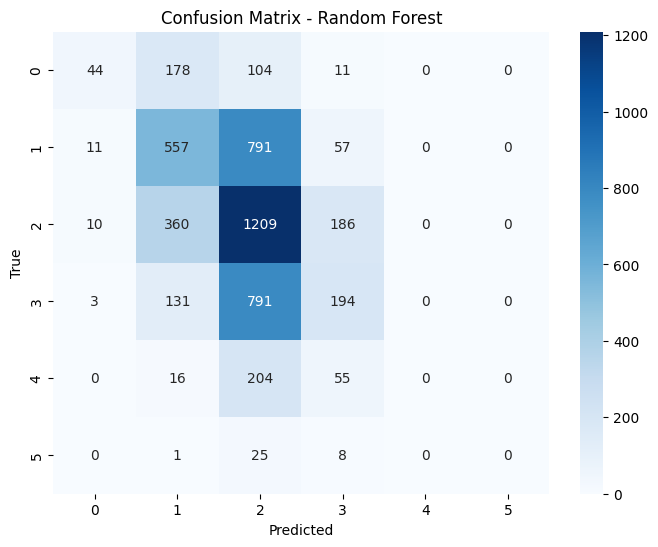

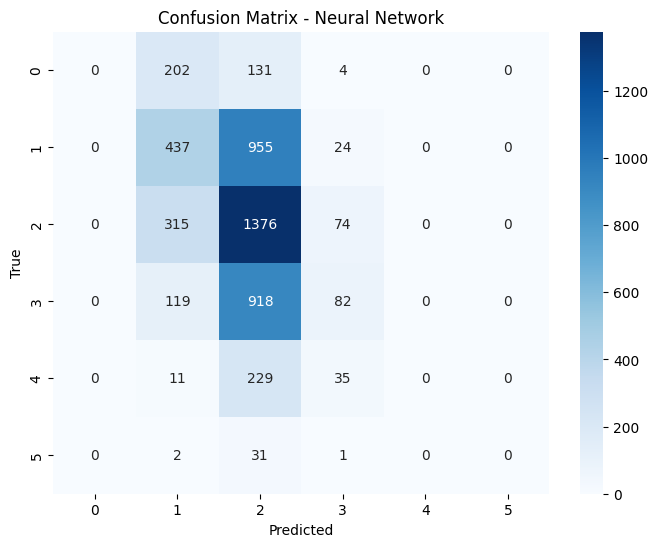

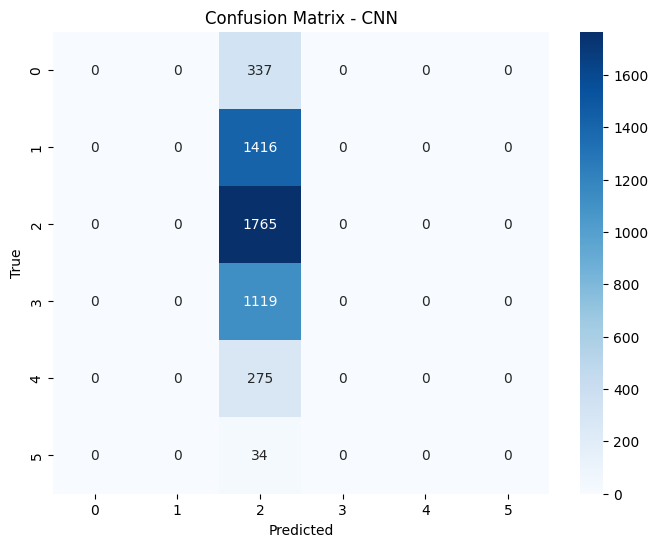


Model Performance Comparison:
          Logistic Regression  Random Forest  Neural Network     CNN
Accuracy               0.4513         0.4052          0.3831  0.3569


In [9]:
# Convert grades to integer classes (subtract 1 to make 0-based)
grades = np.array(grades).astype(int) - 1

# Split data
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, grades, test_size=0.2, random_state=42)

# Dictionary to store results
results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, lr_pred)
}

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, rf_pred)
}

# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Simple Neural Network for Classification
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# CNN Model for Classification
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.height = 16
        self.width = int(input_size / self.height) + (1 if input_size % self.height else 0)
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        conv_output_size = 32 * (self.height//4) * (self.width//4)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, 1, self.height, self.width)
        x = self.conv_layers(x)
        x = x.view(batch_size, -1)
        return self.fc_layers(x)

# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

num_classes = len(np.unique(grades))

# Train neural network
nn_model = SimpleNN(bert_embeddings.shape[1], num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

# Train for 100 epochs
for epoch in range(100):
    optimizer.zero_grad()
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Get predictions for NN
nn_model.eval()
with torch.no_grad():
    nn_pred = torch.argmax(nn_model(X_test_tensor), dim=1).numpy()

results['Neural Network'] = {
    'Accuracy': accuracy_score(y_test, nn_pred)
}

# Plot confusion matrix for Neural Network
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nn_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Train CNN
cnn_model = CNN(bert_embeddings.shape[1], num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Train for 100 epochs
for epoch in range(100):
    optimizer.zero_grad()
    outputs = cnn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Get predictions for CNN
cnn_model.eval()
with torch.no_grad():
    cnn_pred = torch.argmax(cnn_model(X_test_tensor), dim=1).numpy()

results['CNN'] = {
    'Accuracy': accuracy_score(y_test, cnn_pred)
}

# Plot confusion matrix for CNN
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, cnn_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display results in a table
results_df = pd.DataFrame(results).round(4)
print("\nModel Performance Comparison:")
print(results_df)


The confusion matrices show that the models tend to predict scores in the middle range of the distribution (3-4), where the majority of samples are concentrated. The baseline accuracy is set at 0.45 by the logistic regression model.

# LLMs

For the ML models, I excluded contextual data from the input because it was not informative for the task and to avoid adding noise to the evaluation source. However, since LLMs perform better with detailed instructions, I will try also to include this contextual information for them.